In [ ]:
!pip install tensorflow-io

/bin/bash: line 1: conda: command not found


In [ ]:
import os
import tensorflow as tf
#import tensorflow_io as tfio
import tensorflow_datasets as tfds
import librosa
import numpy as np
import librosa.display
import cv2
import matplotlib.pyplot as plt

# Gathering Files

In [ ]:
def audio_loader(audio_path, sr, duration, mono =True, tensor_based = True):
  if tensor_based == False:
    audio = librosa.load(audio_path, sr=sr, duration=duration, mono =mono)[0] # duration is in seconds
  else:
    audio = tf.io.read_file(audio_path)
    if mono == True:
      audio, own_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    else:
      audio, own_sample_rate = tf.audio.decode_wav(audio)
    print(own_sample_rate)
    number_of_samples = tf.shape(audio)[0]
    new_number_of_samples = tf.cast(number_of_samples * sr / own_sample_rate, tf.int32)
    audio = tf.signal.resample(audio, new_number_of_samples)

  if len(audio) < duration * sr:
    audio = reflect_pad(audio, int((duration * sr - len(audio)) / 2))
    if len(audio) < duration * sr:
      audio = np.concatenate((audio,[audio[-1]]))
  return audio

def reflect_pad(signal, pad_width):
    left_pad = signal[1:pad_width+1][::-1]
    right_pad = signal[-pad_width-1:-1][::-1]
    padded_signal = tf.concat((left_pad, signal, right_pad),0)
    #padded_signal = np.concatenate((left_pad, signal, right_pad))
    return padded_signal

# Preprocessing

In [ ]:
test_audio_path= '/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original/rock/rock.00006.wav'
sr=16000
dur=30
test_audio=audio_loader(test_audio_path, sr, dur, tensor_based=False)
print(type(test_audio))
print(test_audio.shape)
print(sr*dur)

#test_audio2 = audio_loader(test_audio_path, sr, dur)
#print(type(test_audio2))
#print(test_audio2.shape)
#print(type(test_audio2))
#print(test_audio2.shape)
#print(sr*dur)
#print(test_audio2[0:2])

<class 'numpy.ndarray'>
(480000,)
480000


In [ ]:
def audio_nomalizer(audio):
  audio_max = np.max(audio)
  audio_min = np.min(audio)
  audio = (audio - audio_min)/(audio_max - audio_min)
  return audio, audio_min, audio_max

def audio_spectrogram_extractor(audio, n_fft=2048, hop_length=1024, expand_dims=False, normalize=False):
  audio_spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  audio_spectrogram = librosa.amplitude_to_db(np.abs(audio_spectrogram), ref=np.max)
  if expand_dims == True:
    audio_spectrogram = np.expand_dims(audio_spectrogram, axis=2)
  if normalize == True:
    audio_spectrogram = (audio_spectrogram - np.min(audio_spectrogram)) / (np.max(audio_spectrogram) - np.min(audio_spectrogram))
  return audio_spectrogram



In [ ]:
test_audio, test_min, test_max = audio_nomalizer(test_audio)
test_audio_spectrogram = audio_spectrogram_extractor(test_audio)
plt.figure(figsize=(10, 6))
librosa.display.specshow(test_audio_spectrogram, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

NameError: name 'test_audio' is not defined

In [ ]:
test_audio_path= '/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original/rock/rock.00006.wav'
all_audios_path = '/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original/'

spectrograms_path = all_audios_path + '../spectrograms_original/'
if not os.path.isdir(spectrograms_path):
  os.mkdir(spectrograms_path)

class_names = os.listdir(all_audios_path)
for class_name in class_names:
  if not os.path.isdir(spectrograms_path + class_name):
    os.mkdir(spectrograms_path + class_name)
  os.chdir(spectrograms_path + class_name)
  for f in os.listdir(all_audios_path + class_name):
    print(all_audios_path + class_name + '/' + f)
    audio = audio_loader(all_audios_path + class_name + '/' + f, sr = 16000, duration = 20, mono =True, tensor_based = False)
    audio , _ , _ = audio_nomalizer(audio)
    spectrogram = audio_spectrogram_extractor(audio, n_fft=2048, hop_length=1024, expand_dims=True, normalize=True)
    spectrogram = np.rint(spectrogram * 255)
    cv2.imwrite(f[:-3] + 'png', spectrogram)
    cv2.waitKey(0)


/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original/blues/blues.00000.wav
/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original/blues/blues.00001.wav
/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original/blues/blues.00002.wav
/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original/blues/blues.00003.wav


KeyboardInterrupt: 

# Dataset Pipeline

In [ ]:
spectrogram_size = (256,256)
dataset = tf.keras.utils.image_dataset_from_directory(spectrograms_path,
                                                      batch_size=64,
                                                      image_size=spectrogram_size,
                                                      shuffle=True,
                                                      color_mode="grayscale")
dataset = dataset.map(lambda x,y: (x/255, y))
dataset_iterator =dataset.as_numpy_iterator()

Found 999 files belonging to 10 classes.


In [ ]:
train_size=int(0.7*len(dataset))
test_size=int(0.1*len(dataset))
validation_size=len(dataset)-train_size-test_size

train_datas=dataset.take(train_size)
test_datas=dataset.skip(train_size).take(test_size)
validation_datas=dataset.skip(train_size + test_size).take(validation_size)


# Dataset Pipeline (incomplete)

In [ ]:
# UNUSED CODE (TODO!!)

path='/content/drive/MyDrive/Music Genre Classification/rawDatas/Data/genres_original'
all_classes_path = os.listdir(path)

datas_tf_list = []
classes_dataset = []
for i, class_path in enumerate(all_classes_path):
  #all_audios_path = [f for f in os.listdir(path) if f.endswith('.wav')]
  #for audio_path in all_audios_path:
  datas_tf_list.append(tf.data.Dataset.list_files(os.path.join(path, class_path, '*.wav')))
  classes_dataset.append(tf.data.Dataset.zip((datas_tf_list[i],tf.data.Dataset.from_tensor_slices(tf.ones(len(datas_tf_list[i])) * i))))


for i, class_dataset in enumerate(classes_dataset) :
  if i==0:
    dataset = class_dataset
  else:
    dataset = dataset.concatenate(class_dataset)

dataset = dataset.shuffle(buffer_size=10000)


# Model Desigin

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=spectrogram_size+(1,)))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# If a GPU is available, TensorFlow should list it here
for device in physical_devices:
    print(device)

with tf.device('/GPU:0'):
    model = model

model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 256)               132129024 
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 132131914 (504.04 MB

# Model Training



In [ ]:
hist = model.fit(train_datas, epochs=20, validation_data=validation_datas)

Epoch 1/20
11/11 [==============================] - 13s 1s/step - loss: 0.1499 - accuracy: 0.9830 - val_loss: 0.1001 - val_accuracy: 0.9957
Epoch 2/20
11/11 [==============================] - 14s 1s/step - loss: 0.0924 - accuracy: 0.9901 - val_loss: 0.0764 - val_accuracy: 1.0000
Epoch 3/20
11/11 [==============================] - 16s 1s/step - loss: 0.0689 - accuracy: 0.9943 - val_loss: 0.0735 - val_accuracy: 0.9913
Epoch 4/20
11/11 [==============================] - 13s 1s/step - loss: 0.0362 - accuracy: 0.9986 - val_loss: 0.0305 - val_accuracy: 0.9957
Epoch 5/20
11/11 [==============================] - 16s 1s/step - loss: 0.0265 - accuracy: 0.9972 - val_loss: 0.0266 - val_accuracy: 0.9957
Epoch 6/20
11/11 [==============================] - 16s 1s/step - loss: 0.0188 - accuracy: 0.9972 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 7/20
11/11 [==============================] - 13s 997ms/step - loss: 0.0136 - accuracy: 0.9972 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 8/20
11/11 

# Results

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test_datas.as_numpy_iterator():
  X, y = batch
  y = tf.keras.utils.to_categorical(y, 10)
  yhat = model.predict(X)
  max_index = np.argmax(yhat, axis=1)
  yhat = tf.keras.utils.to_categorical(max_index, 10)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

2/2 [==============================] - 0s 10ms/step
Precision: 0.9985795617103577, Recall:0.9985795617103577, Accuracy:0.9997159242630005


2/2 [==============================] - 0s 10ms/step


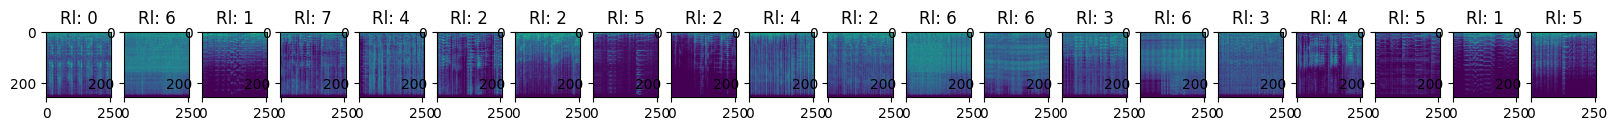

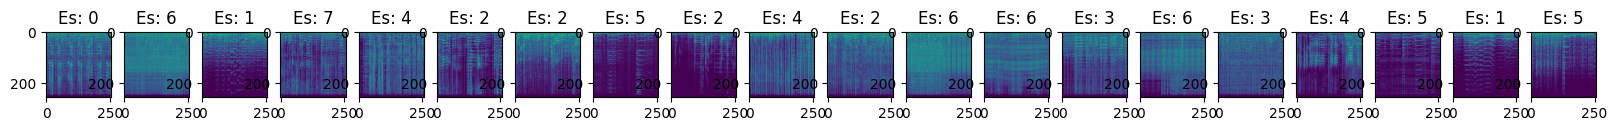

In [ ]:
test_batch=dataset_iterator.next()
test_num=20
fig, ax=plt.subplots(ncols=test_num, figsize=(20,20))
#fig.suptitle('y')
for idx, img in enumerate(test_batch[0][0:test_num]*255):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(f'Rl: {test_batch[1][idx]}')

test_batch_yhat=np.argmax(model.predict(test_batch[0]), axis=1)
fig2, ax2=plt.subplots(ncols=test_num, figsize=(20,20))
for idx, img in enumerate(test_batch[0][0:test_num]*255):
  ax2[idx].imshow(img.astype(int))
  ax2[idx].title.set_text(f'Es: {test_batch_yhat[idx]}')